# Metadata Setup

For this notebook we will be building dataframes to hold any metadata information about CT scans that we need for training

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '../')

In [80]:
import os
import pickle
import feather
import random
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import namedtuple
Path.ls = lambda x: [o.name for o in x.iterdir()]

In [4]:
# Load environment variables to get local datasets path
from dotenv import load_dotenv
load_dotenv()
data_dir = os.environ.get('datasets_path')

Load the provided excel metadata and save paths to train and validation

In [5]:
dataset_path = Path(f'{data_dir}/COVID-19-20_v2')
trn_path = dataset_path/'Train'
val_path = dataset_path/'Validation'

In [6]:
trn_volumes = pd.read_excel(dataset_path/'COVID-19-20_TrainValidation.xlsx')

## File locations

First we organize the file path information in a dataframe for easy mapping between the IDs and their segmentation mask or CT volume

In [7]:
# train
trn_ct_fnames = list((trn_path/trn_volumes.FILENAME).astype(str) + '_ct.nii.gz')
trn_mask_fnames = list((trn_path/trn_volumes.FILENAME).astype(str) + '_seg.nii.gz')
trn_uid = list(trn_volumes.FILENAME.str[18:])

In [8]:
# valid
val_ct_list = pd.Series(val_path.ls())
val_ct_fnames = list((val_path/val_ct_list).astype(str))
val_uid = [val[18:23] if len(val) > 31 else val[18:21] for val in val_ct_list]

In [9]:
ct_fnames = trn_ct_fnames + val_ct_fnames
mask_fnames = trn_mask_fnames + ['']*len(val_ct_list)
uid = trn_uid + val_uid
is_valid = [False]*len(trn_ct_fnames) + [True]*len(val_ct_list)

In [10]:
df_meta = pd.DataFrame({'uid': uid,
                        'ct_fname': ct_fnames,
                        'mask_fname': mask_fnames,
                        'is_valid': is_valid})

In [11]:
df_meta.head()

,uid,ct_fname,mask_fname,is_valid
0,391,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,False
1,383_1,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,False
2,338,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,False
3,623,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,False
4,559,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,/mnt/16614710-4b50-44ce-a3f3-13105cdf14ad/data...,False


Assuming the `_1` or `_0` suffix on the id mean that it is either a duplicate or additional scan, we can drop the suffix and treat it as the same patient so we can keep it in the same train/validation set later on

In [12]:
df_meta['stripped_uid'] = df_meta.uid.str.replace('_1', '')
df_meta['stripped_uid'] = df_meta.stripped_uid.str.replace('_0', '')
len(df_meta.stripped_uid) > len(set(df_meta.stripped_uid))

False

Turns out the suffixes were not indicative of duplicates/additional scans for a patient, at least not for our training set

In [13]:
df_meta.drop('stripped_uid', axis=1, inplace=True)

## CT Header Info

Add the metadata from the header of each CT scan to df_meta for exploratory data analysis (EDA) purposes

In [14]:
# note that nibabel's get_fdata() function will cast the datatype of the ct array to float automatically
# so we do not have to handle any explicit data conversions
def append_header_meta(df, ct_fnames, mask_fnames):
    meta_dict = {}
    fnames = zip(ct_fnames, mask_fnames)
    for _, (ct_fname, mask_fname) in tqdm(enumerate(fnames), total=len(ct_fnames)):
        ct = nib.load(ct_fname)
        hdr = ct.header
        header_cols = set(list(hdr))
        for key in header_cols:
            if hdr[key].size > 1:
                for i, value in enumerate(hdr[key]):
                    meta_dict.setdefault(f'{key}_{i}',[]).append(value)
            else:
                meta_dict.setdefault(key,[]).append(hdr[key].item())
        img = ct.get_fdata()
        meta_dict.setdefault('img_min',[]).append(img.min())
        meta_dict.setdefault('img_max',[]).append(img.max())
        meta_dict.setdefault('img_mean',[]).append(img.mean())
        meta_dict.setdefault('img_std',[]).append(img.std())
        
        if len(mask_fname):
            mask = nib.load(mask_fname)
            img_mask = mask.get_fdata()
            meta_dict.setdefault('pct_lesion',[]).append(img_mask.sum() / img_mask.size)
        else:
            meta_dict.setdefault('pct_lesion',[]).append(0.)
        
    for key in meta_dict:
        df[key] = meta_dict[key]

In [15]:
append_header_meta(df_meta, df_meta.ct_fname, df_meta.mask_fname)

100%|██████████| 249/249 [01:38<00:00,  2.53it/s]


In [16]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', 30): 
    display(df_meta.head().T)

,0,1,2,3,4
uid,391,383_1,338,623,559
ct_fname,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...
mask_fname,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...,/mnt/16614710-4b50-44ce-a3...
is_valid,False,False,False,False,False
intent_name,b' ',b' ',b' ',b' ',b' '
sizeof_hdr,348,348,348,348,348
cal_min,0,0,0,0,0
bitpix,16,16,16,16,16
cal_max,0,0,0,0,0
srow_x_0,0,0,0,0,0


In [17]:
# df_meta.to_feather('../df_meta.fth')

## Lesion Center Point Voxel Locations

In [7]:
df_meta = pd.read_feather('../df_meta.fth')

As revealed from EDA, we are dealing with a very small amount of lesion data per CT. When training our model, we will need to perform some upsampling on the training data by zooming into these lesions

In [24]:
from modules.dsets import Ct

In [25]:
uid_trn_list = df_meta[df_meta.is_valid==False].uid

In [26]:
lesion_header = ['uid', 'coordI', 'coordR', 'coordC', 'min_index', 'max_index', 'min_row', 'max_row', 'min_column', 'max_column', 'largest_side_px'] 

In [27]:
lesion_locations = []
for uid in tqdm(uid_trn_list):
    ct = Ct(uid)
    lesion_locations = lesion_locations + ct.group_lesions(output_df=False)

100%|██████████| 199/199 [05:27<00:00,  1.64s/it]


In [28]:
len(lesion_locations)

1237

In [29]:
df_lesion_coords = pd.DataFrame(lesion_locations, columns=lesion_header)

In [30]:
df_lesion_coords.head()

,uid,coordI,coordR,coordC,min_index,max_index,min_row,max_row,min_column,max_column,largest_side_px
0,391,27,296,215,26,30,280,314,196,231,35
1,383_1,23,311,132,23,24,309,314,131,134,5
2,383_1,25,313,138,24,28,307,321,131,145,14
3,383_1,39,242,227,37,43,221,272,208,247,51
4,338,25,343,203,25,26,342,344,199,208,9


In [31]:
# df_lesion_coords.to_feather('../df_lesion_coords.fth')

## Voxel Normalization

Normalization technique learned from https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai

It basically suggests to normalize the data by scaling the voxels based on the distributions of the voxels themselves.

In [5]:
from modules.util.util import array_freqhist_bins, hist_scaled, window_image
df_meta = pd.read_feather('../df_meta.fth')

In [13]:
# sample ct's from each pixel representation from the training data
df_meta_16 = df_meta[df_meta.is_valid==False].query('bitpix==16')
df_meta_64 = df_meta[df_meta.is_valid==False].query('bitpix==64')
len(df_meta_16), len(df_meta_64)

(196, 3)

In [21]:
sample_fnames = pd.concat([df_meta_16.ct_fname.sample(10), df_meta_64.ct_fname])

In [35]:
sample_cts = [nib.load(fname).get_fdata().T for fname in sample_fnames]

In [42]:
sample_arrays = []
for ct in sample_cts:
    rand_indices = np.random.choice(ct.shape[0], 10, replace=False)
    sample_arrays.append(ct[rand_indices])
samples = np.stack(sample_arrays)

In [49]:
samples = np.stack(sample_arrays)
samples_lung_window = window_image(samples, 'lung')

In [50]:
bins = array_freqhist_bins(samples)
bins_lung_window = array_freqhist_bins(samples_lung_window)

In [63]:
with open('../bins.pkl', 'wb') as handle:
    pickle.dump(bins, handle)
with open('../bins_lung_window.pkl', 'wb') as handle:
    pickle.dump(bins_lung_window, handle)

In [65]:
with open('../bins.pkl', 'rb') as handle:
    bins = pickle.load(handle)
with open('../bins_lung_window.pkl', 'rb') as handle:
    bins_lung_window = pickle.load(handle)

Now that we have the bins for normalization, we can test it out

In [119]:
img = samples[0][0]
img_lung_window = samples_lung_window[0][0]
img_normalized = hist_scaled(img, bins)
img_lung_window_normalized = hist_scaled(img_lung_window, bins_lung_window)

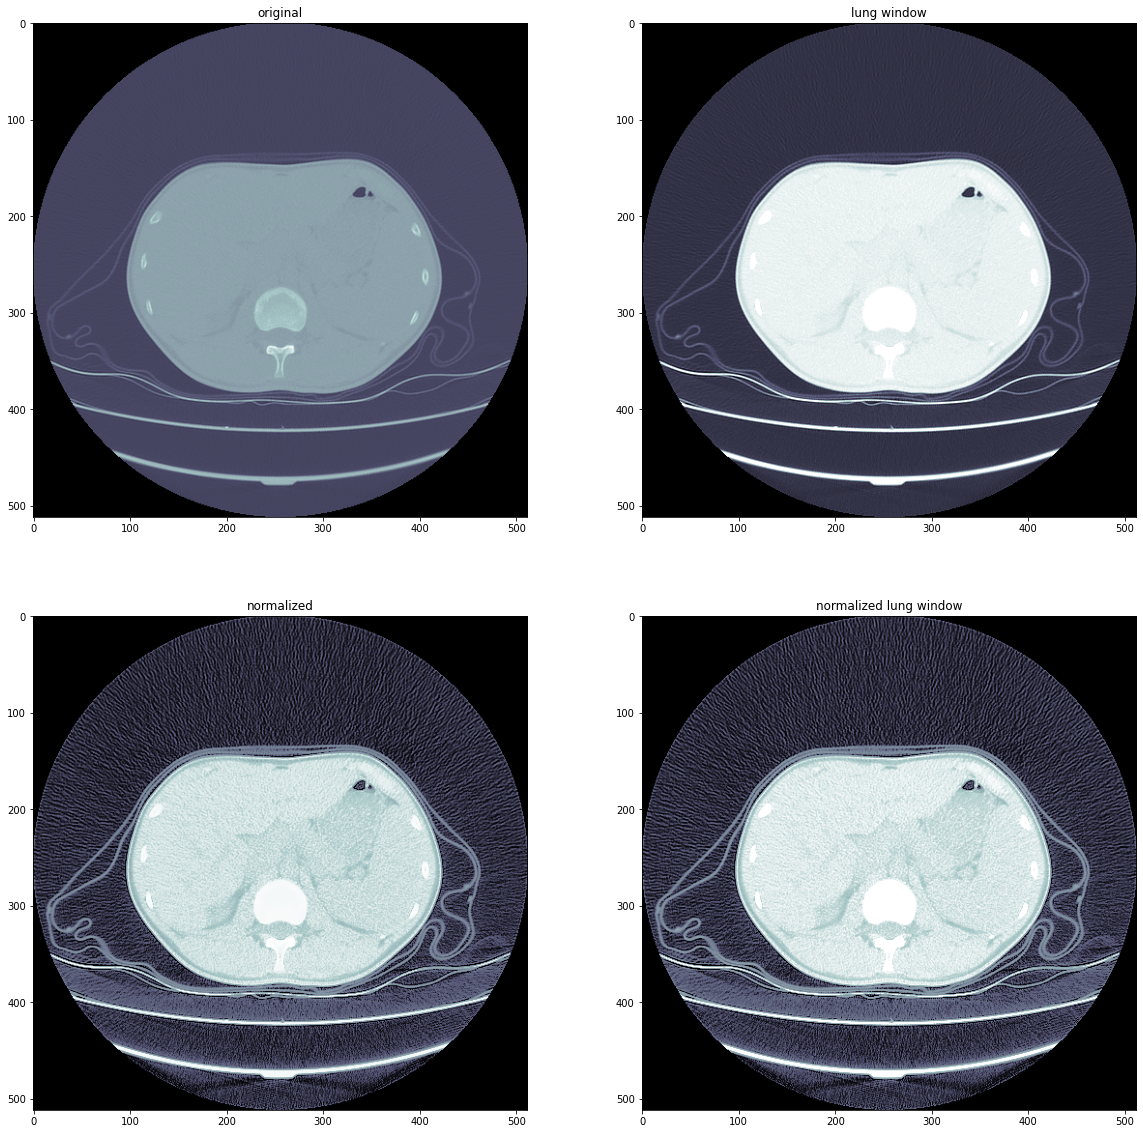

In [120]:
cmap='bone'
fig, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0][0].set_title('original')
ax[0][1].set_title('lung window')
ax[1][0].set_title('normalized')
ax[1][1].set_title('normalized lung window')
ax[0][0].imshow(img, cmap=cmap)
ax[0][1].imshow(img_lung_window, cmap=cmap)
ax[1][0].imshow(img_normalized, cmap=cmap)
ax[1][1].imshow(img_lung_window_normalized, cmap=cmap)